# Out-of-scope Doc2Vec
Creates Doc2Vec representations from the OOS list.

In [1]:
%pip install pandas gensim matplotlib scikit-learn pycld2 beautifulsoup4 geoip2

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports
import re
from collections import Counter
from pprint import pprint
import time

import pandas as pd
import tensorboard as tb
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%load_ext tensorboard

Generate Doc2Vec for websites.

In [20]:
data_path = "res/news_temp.csv"
file = pd.read_csv(data_path)
file.describe()

,timestamp,last_modified,norvegica_score,language.text_bytes_found,language.details.0.percent,language.details.0.score,language.details.1.percent,language.details.1.score,language.details.2.percent,language.details.2.score,...,regex.county.unique,regex.county.total,regex.name.unique,regex.name.total,regex.norway.unique,regex.norway.total,regex.kroner.unique,regex.kroner.total,regex.email.unique,regex.email.total
count,2.721400e+04,2.270000e+03,27214.000000,27214.000000,27214.000000,27214.000000,27214.000000,27214.000000,27214.000000,27214.000000,...,27214.000000,27214.000000,27214.000000,27214.000000,27214.000000,27214.000000,27214.000000,27214.000000,27214.000000,27214.000000
mean,1.592112e+09,1.588043e+09,0.937532,7189.437238,97.573014,851.390093,0.481774,86.639377,0.016903,5.052326,...,0.978687,2.769383,1.626957,2.159036,0.878592,2.262475,0.714706,0.918094,1.266554,1.375285
std,9.978555e+04,1.225611e+07,0.093705,8843.155948,8.261505,115.418091,1.907234,248.252908,0.227159,58.412139,...,2.229474,5.768105,2.652187,3.854545,1.035668,4.681814,0.994472,1.479765,2.466729,2.593167
min,1.591942e+09,1.538043e+09,0.159104,43.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.592024e+09,1.591974e+09,0.928056,3001.000000,99.000000,803.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.592111e+09,1.592078e+09,0.958045,4417.000000,99.000000,859.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.592197e+09,1.592179e+09,0.975335,8996.000000,99.000000,905.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,3.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000
max,1.592284e+09,1.592291e+09,0.997255,118874.000000,99.000000,3390.000000,22.000000,1752.000000,6.000000,1098.000000,...,37.000000,60.000000,30.000000,39.000000,5.000000,44.000000,9.000000,15.000000,22.000000,23.000000


In [4]:
print(len(file["original_url"].unique()))

283


In [5]:
class TaggedWebpageDocument(object):
    def __iter__(self):
        for i, row in file.iterrows():
            url, text = row["original_url"], str(row["text"]).lower()
            words = [c for c in re.split(r"\W+", text) if len(c) > 0]
            yield TaggedDocument(words, [f"{url}@{row['timestamp']}"])


documents = TaggedWebpageDocument()
t0 = time.time()
model = Doc2Vec(documents, window=7, vector_size=256, workers=4)
t1 = time.time()
print(t1 - t0)
model.save("oos-doc2vec")

319.51482605934143


In [6]:
model = Doc2Vec.load("oos-doc2vec")

Small tests.

In [8]:
pprint(model.docvecs.most_similar(positive=["http://www.vg.no/@1591941652"], topn=10))
pprint(model.docvecs.most_similar(positive=["https://www.nrk.no/nyheter/@1591941624"], topn=10))
pprint(model.docvecs.most_similar(positive=["https://www.ranablad.no/@1591941648"], topn=10))

[('http://www.vg.no/@1591945249', 0.8638827800750732),
 ('http://www.vg.no/@1591948845', 0.8528187274932861),
 ('http://www.vg.no/@1591952442', 0.7945458889007568),
 ('http://www.vg.no/@1591956039', 0.7919875383377075),
 ('http://www.vg.no/@1591959636', 0.7476581931114197),
 ('http://www.vg.no/@1591963233', 0.7415838837623596),
 ('http://www.vg.no/@1592006402', 0.7389625310897827),
 ('http://www.vg.no/@1591999205', 0.7266556024551392),
 ('http://www.vg.no/@1591966829', 0.7248575091362),
 ('http://www.vg.no/@1592017196', 0.7197355628013611)]
[('http://www.abcnyheter.no/@1591963234', 0.4788393974304199),
 ('http://www.abcnyheter.no/@1592020796', 0.47651931643486023),
 ('http://www.abcnyheter.no/@1591992012', 0.47352588176727295),
 ('http://www.abcnyheter.no/@1591966831', 0.46877190470695496),
 ('http://www.abcnyheter.no/@1592038789', 0.4674818515777588),
 ('https://www.klartale.no/@1592042363', 0.46714669466018677),
 ('https://www.nrk.no/nyheter/@1592143162', 0.4650852084159851),
 ('http

Run dimensionality reduction.

(27214, 256)


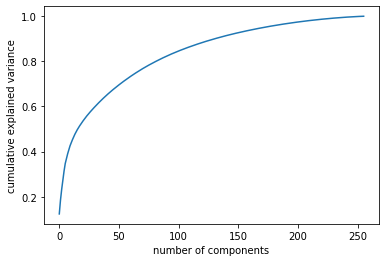

In [9]:
pca = PCA()

trans = pca.fit_transform(model.docvecs.vectors_docs)

print(trans.shape)

# Plot explained variance (information kept) vs number of components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [ ]:
# reduced = TSNE().fit_transform(trans)

# np.save("veidemann-reduced.npy", reduced)

In [ ]:
# reduced = np.load("veidemann-reduced.npy")


Write to CSV for later analysis.

In [10]:
print(len(file), model.docvecs.vectors_docs.shape)
vector_df = pd.DataFrame(data=model.docvecs.vectors_docs, columns=[f"v{i}" for i in range(256)])
conc = pd.concat([file, vector_df], axis=1)
conc.to_csv("oos-doc2vec.csv", index=False)

27214 (27214, 256)


In [11]:
# Find low scoring websites that are most similar to high scoring websites.
# pprint(model.docvecs.most_similar(
#     positive=[row["original_url"] for i, row in conc.iterrows() if row["norvegica_score"] > 0.5], topn=30))

TypeError: '<' not supported between instances of 'str' and 'int'

For converting to [TensorFlow embedding projector](https://projector.tensorflow.org/) compatible format

In [12]:
fn = "oos-doc2vec.csv"
csv = pd.read_csv(fn, index_col=False)

csv = csv.dropna(subset=[f"v{i}" for i in range(256)])
csv = csv.fillna("missing")

filt = "v\d+"
vec = csv.filter(regex=filt)
meta = csv.drop(vec.columns, axis=1)
# meta = meta.drop("text", axis=1)
for column in meta:
    try:
        meta[column] = meta[column].str.replace("\n", " ")
    except AttributeError:
        pass

meta = meta.set_index("original_url")

vec.to_csv(fn.replace(".csv", "-vec.tsv"), header=False, sep="\t", index=False)
meta.to_csv(fn.replace(".csv", "-meta.tsv"), sep="\t", index=True)

In [18]:
%tensorboard --bind_all --logdir logs --path_prefix /tensorboard

In [17]:
# !kill 1573

In [19]:
import os
import tensorflow as tf
from tensorboard.plugins import projector
log_dir = "logs"
weights = tf.Variable(model.docvecs.vectors_docs)
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = '../oos-doc2vec-meta.tsv'
projector.visualize_embeddings(log_dir, config)

In [ ]:
%config IPCompleter.greedy=True

For Weka compatibility

In [ ]:
import arff
conc_notxt = conc.drop("text", axis=1).fillna("missing")
arff.dump("oos.arff", conc_notxt.values, "ooslist", conc_notxt.columns)

Generate bar charts and histograms for DataFrame

In [ ]:
nominal = (1,2,3,4,6,7,10,11,14,15,23)

for index in range(len(meta.columns)):
    column = meta.iloc[:, index]
    if index+1 not in nominal:
        if column.dtype == np.float64:
            chart = plt.hist(column.values, bins=101, bottom=0)
        elif column.dtype == np.int64:
            chart = plt.hist(column.values, bins=min(max(column.values)+1, 101), bottom=0)
        else:
            continue
    else: 
        counter = Counter(column)
        labels, values = zip(*counter.most_common(20))
        indexes = np.arange(len(labels))
        width=1
        chart = plt.bar(indexes, values, width)
        plt.xticks(indexes, labels, rotation=90)
    plt.semilogy()
    plt.suptitle(column.name, y=0.95)
    # plt.tight_layout()
    plt.savefig(f"{column.name}.png", bbox_inches="tight")
    plt.clf()

In [ ]:
from urllib import request
import json
r = request.urlopen("http://veidemann-health-check-api:80/health")
print(json.dumps(json.loads(r.read()), indent=1))